In [26]:
import os
import numpy as np
import pandas as pd
import sklearn as slr
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

In [2]:
# Set wd
os.chdir("C://Users/alxgr//Documents//UVA//DSI//Fall 2018//SYS//Kaggle Competition 3//sys6018-competition-blogger-characteristics//data")
# os.chdir("/Users/SM/DSI/classes/fall2018/SYS6018/kaggle/sys6018-competition-blogger-characteristics/")

In [3]:
# read in data
# train = pd.read_csv(os.path.join("data", "input", "train.csv"))
# test = pd.read_csv(os.path.join("data", "input", "test.csv"))

# (os.path did not work for alex.  below for wd on alex's pc)
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
# convert to datetime, leaving non-valid/non-English dates null
train['date_date'] = pd.to_datetime(train.date, errors='coerce')
test['date_date'] = pd.to_datetime(test.date, errors='coerce')

In [5]:
# Remove rows where date cannot be parsed - these are non-English and so unless translated
# into English, cannot be used in a text model with this corpus
train = train[train['date_date'].notnull()]
train.date = train.date_date
train = train.drop(['date_date'], axis=1)

(0, 50)

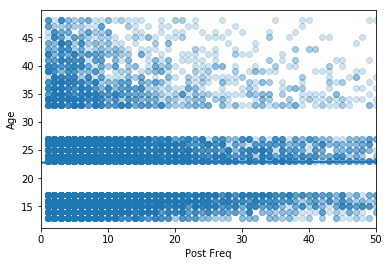

In [15]:
# Exploratory analysis

idfreq = train.groupby(['user.id']).agg({'post.id':[len], 'age':[max]})
idfreq.columns = idfreq.columns.droplevel(1)
idfreq

idfreq.columns= ["Post Freq", "Age"]

sns.regplot(x='Post Freq', y='Age', data=idfreq, scatter_kws={'alpha':0.2})
plt.xlim(0, 50)


(0, 500)

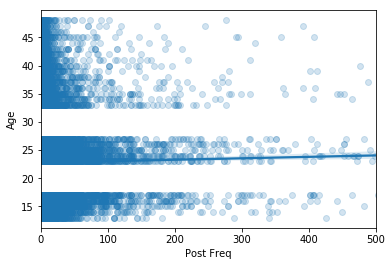

In [16]:
sns.regplot(x='Post Freq', y='Age', data=idfreq, scatter_kws={'alpha':0.2})
plt.xlim(0, 500)


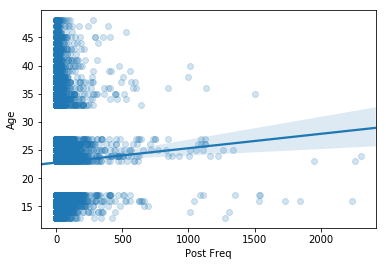

In [17]:
sns.regplot(x='Post Freq', y='Age', data=idfreq, scatter_kws={'alpha':0.2})

In [19]:
age_per_topic = train.groupby(['topic']).agg({"age" : [np.mean]})
age_per_topic

,age
,mean
topic,
Accounting,26.083295
Advertising,29.439648
Agriculture,23.636136
Architecture,25.749260
Arts,24.717653
Automotive,28.759259
Banking,26.036380
Biotech,23.045685


In [18]:
# nltk.download('stopwords')
# nltk.download('punkt')

In [20]:
porter = nltk.stem.porter.PorterStemmer()
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
train['text'] = train['text'].apply(str.lower) # lowercase, tokenize & stem words in text
train['tokens']=train['text'].apply(nltk.word_tokenize) # separate by words/punctuation/etc.
train['tokens']=[[porter.stem(x) for x in tokens] for tokens in train['tokens']] # stem words
train['tokens']=[[w for w in tokens if not w in stop_words] for tokens in train['tokens']] # stop words
train['tokens']=[[w for w in tokens if w.isalpha()] for tokens in train['tokens']]

first tokens line: for each cell in text column, produces a list of tokens

second line: for each list in series of lists (the column), look at a single token, run the stemmer on each token

third line: for each of the cells, look at each list of tokens (now stemmed), check if each individual token (a word) is a stopword

fourth line: for each of the cells, look at the list of tokens (stemmed, not stop words), filter out anything that is not strictly alphabetic characters (excludes punctuation and numeric that might have been confused by the stemmer)

In [21]:
train['newtext'] = train['tokens'].apply(lambda x: " ".join(x)) # concatenate tokens within a cell

In [75]:
# save each document with reduced text to csv
train['newtext'].to_csv("Corpus.csv")

In [82]:
# Create Term-Document Matrix (edited below for dimension reduction)
# vectorizer = slr.feature_extraction.text.CountVectorizer()
# tdm = vectorizer.fit_transform(train['newtext'])

In [86]:
# Reduce TDM Dimensionality
vectorizer = slr.feature_extraction.text.CountVectorizer(min_df=.0005)
tdm_reduced = vectorizer.fit_transform(train['newtext'])
tdm_reduced

<438492x9270 sparse matrix of type '<class 'numpy.int64'>'
	with 29732058 stored elements in Compressed Sparse Row format>

In [72]:
# Saving vectorizer headings
feature_headings = vectorizer.get_feature_names()

In [66]:
# TFIDF transform
transformer = slr.feature_extraction.text.TfidfTransformer(smooth_idf=False)
tfidf = transformer.fit_transform(tdm_reduced)

In [30]:
sp.sparse.save_npz("Training_TF_IDF_01.npz", tfidf)

In [78]:
# tfidf.to_csv("Training_TF_IDF_01.csv")
# tfidf.todense() # it is too big of a file to do this
type(tfidf)

scipy.sparse.csr.csr_matrix

In [31]:
tfidf = sp.sparse.load_npz("Training_TF_IDF_01.npz")
# np_array_tfidf = np.load("Training_TF_IDF_01.npz")

In [87]:
array_tfidf= np.asarray(tfidf)
# np_array_tfidf['data'] # this did not work 

BadZipFile: Bad CRC-32 for file 'data.npy'